In [278]:
import json
import os
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import training_scripts.domain.sampler as sampler
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import math
import numpy as np


In [213]:
def load_data(directory):
    data_dicts = []
    for file in os.listdir(directory):
        with open(os.path.join(directory, file), 'r') as f:
            data_dict = json.load(f)
        data_dicts.append(data_dict)
    return data_dicts

In [214]:
def build_dataframe(data_dicts):
    return pd.json_normalize(data_dicts)


def reformat_dataframe(df, columns_to_keep):
    df = df.rename(columns_to_keep, axis=1)
    df = df[list(columns_to_keep.values())]
    return df

In [262]:
def drop_unlabeled_data(df, column):
    return df[(df[column] == True) | (df[column] == False)]

def balance_data(df, column):
    df_grouped = df.groupby(column)
    sample_size = df_grouped.size().min()

    def sample(df):
#         return df.sample(sample_size).reset_index(drop=True)
        return df.sample(sample_size)

    df_grouped_sampled = df_grouped.apply(sample)
    df_sampled = pd.DataFrame(df_grouped_sampled)
    df_sampled = df_sampled.droplevel(level=0)
    
    sampled_indeces = df_sampled.index.values
    df_not_sampled = df[~df.index.isin(sampled_indeces)]
    return (df_not_sampled, df_sampled)

In [216]:
def count_keywords(df, columns, keywords):
    for keyword in keywords:

        def count_keyword(string):
            return sum(
                keyword in word
                for word in string.lower().split())

        df[keyword] = df[columns].applymap(count_keyword).sum(axis=1)
    return df

In [247]:
def plot_confusion_matrices(classifiers, x,y,normalize=None, nrows = 1):
    ncols = math.ceil(len(classifiers)/nrows)
    fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(ncols*5,nrows*3.7))
    for cls, ax in zip(classifiers, axes.flatten()):
        plot_confusion_matrix(cls,
                      x, 
                      y,
                      ax=ax, 
                      cmap='Blues',
                      normalize = normalize,
                     display_labels=['Not COVID','COVID'])
        ax.title.set_text(type(cls).__name__)
    plt.tight_layout()  
    plt.show()

In [248]:
directory = '../data/news_articles/balanced_dataset/'
data = load_data(directory)

df = build_dataframe(data)

columns_to_keep = {
    'LABEL.WANT_ON_MAP': 'label',
    'ARTICLE.TEXT': 'text',
    'ARTICLE.TITLE': 'title'}
df = reformat_dataframe(df, columns_to_keep)

column = 'label'
df = drop_unlabeled_data(df, column)

columns = [
    'text',
    'title']
keywords = [
    'covid',
    'corona',
    'pandem',
    'epidem',
    'mask',
    'quarant']
df = count_keywords(df, columns, keywords)

(test, train) = balance_data(df, column)

classifiers = [RandomForestClassifier(n_estimators=50, random_state=0), 
               LogisticRegression()]

for cls in classifiers:
    cls.fit(train[keywords], train[column].astype(bool))

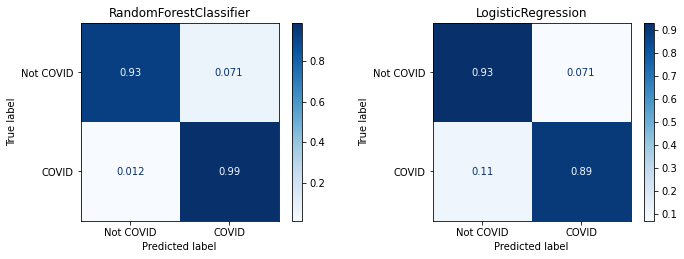

In [249]:
plot_confusion_matrices(classifiers, train[keywords], train[column].astype(bool), normalize='true')

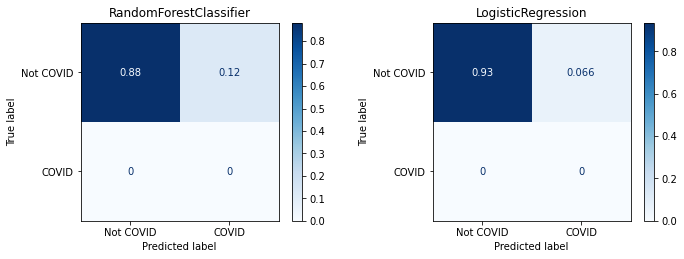

In [250]:
plot_confusion_matrices(classifiers, test[keywords], test[column].astype(bool),normalize='true')

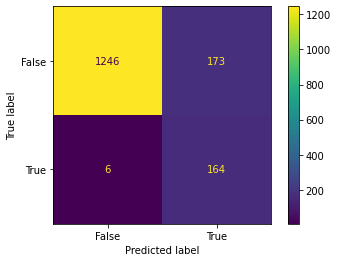

In [243]:

import joblib
knn =classifiers[0] 
# Save the model as a pickle in a file
joblib.dump(knn, 'logistic_regression.pkl')
  
# Load the model from the file
knn_from_joblib = joblib.load('logistic_regression.pkl') 
  
# Use the loaded model to make predictions
plot_confusion_matrix(classifiers[0], df[keywords], df[column].astype(bool))

In [316]:
def vectorize(df):
    train = df['text'] 
    # instantiate the vectorizer object
    tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')
    # convert th documents into a matrix
    tfidf_wm = tfidfvectorizer.fit_transform(train)
    tfidf_tokens = tfidfvectorizer.get_feature_names()
    top_tokens = get_top_features(tfidfvectorizer, tfidf_wm, 10)
#     print(top_tokens)
    df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),columns =tfidf_tokens)
    return df_tfidfvect[top_tokens].copy()
def get_top_features(tfidf,response, n=10):
    feature_array = np.array(tfidf.get_feature_names())
    tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
    top_n = feature_array[tfidf_sorting][:n] 
    return top_n

(1857, 13)
(164, 13)



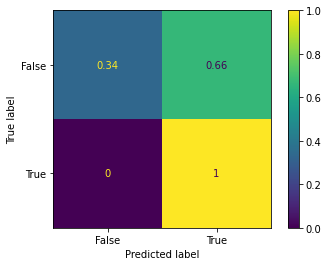

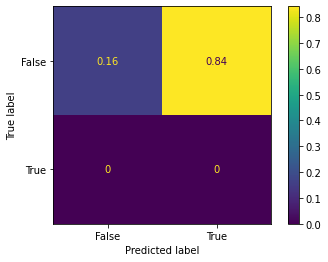

In [317]:
# def balance_data(df, column):
#     df_grouped = df.groupby(column)
#     sample_size = df_grouped.size().min()

#     def sample(df):
#         return df.sample(sample_size).reset_index(drop=True)

#     df_grouped_sampled = df_grouped.apply(sample)
#     df_sampled = pd.DataFrame(df_grouped_sampled)
#     df_sampled = df_sampled.droplevel(level=0)
#     return df_sampled
def sample_data(df, column):
#     true = df[df[column] == True].sample(frac = .5)
#     false = df[df[column] == False].sample(frac = .1)
#     return pd.concat(
#         [
#             true,
#             false 
#         ]
#     )
    return df.sample(frac=.25)
directory = '../data/news_articles/balanced_dataset/'
data = load_data(directory)

df = build_dataframe(data)

columns_to_keep = {
    'LABEL.WANT_ON_MAP': 'LABELLLLLL',
    'ARTICLE.TEXT': 'text',
    'ARTICLE.TITLE': 'title'}
df = reformat_dataframe(df, columns_to_keep)

column = 'LABELLLLLL'
df = drop_unlabeled_data(df, column)

columns = [
    'LABELLLLLL',
    'text',
    'title']
#df = count_keywords(df, columns, keywords)
df[column].value_counts()
df.head()
df = pd.concat(
    [
        df,
        vectorize(df)
    ], axis=1
)
print(df.shape)
df =df.dropna()
print(df[df[column] == True].shape)
print()

# balanced = sample_data(df,column)
(test, train) = balance_data(df, column)

# print(balanced.shape)
# print(balanced[balanced[column] == True].shape)

model = RandomForestClassifier().fit(train.drop(columns , axis = 1), train[column].astype(bool))
# model = fit_bayes(train.drop(columns , axis = 1), train[column].astype(bool))

plot_confusion_matrix(model, train.drop(columns , axis = 1), train[column].astype(bool),normalize='true')
plot_confusion_matrix(model, test.drop(columns , axis = 1), test[column].astype(bool),normalize='true')

In [259]:
from sklearn.naive_bayes import MultinomialNB
def fit_bayes(x,y):
    clf = MultinomialNB().fit(x, y)
    return clf
def fit_grid_search(x,y):
    clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
    return clf

In [ ]:
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, n_iter=5, random_state=42)),
])
_ = text_clf_svm.fit(twenty_train.data, twenty_train.target)
predicted_svm = text_clf_svm.predict(twenty_test.data)
np.mean(predicted_svm == twenty_test.target)

In [266]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train', shuffle=True)

In [268]:
twenty_train.target_names #prints all the categories
print("\n".join(twenty_train.data[0].split("\n")[:10])) #prints first line of the first data file

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 


In [269]:

twenty_train.head()

AttributeError: head